In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import math
import itertools
import pandas

import metrics
import simulate
import harvesting
import market
import withdrawal
import numpy
import mortality
import montecarlo

In [2]:
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [3]:
series = market.Returns_US_1871()

In [4]:
def mk_lens(type_):
    m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
         'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
         'Portfolio (Nominal)': lambda x: float(x.portfolio_pre.value_n),
         'Portfolio (Real)': lambda x: float(x.portfolio_pre.value_r),
         'Bond %': lambda x: float(x.portfolio_pre.bonds / (x.portfolio_pre.bonds + x.portfolio_pre.stocks))
    }
    lens = m[type_]
    lens.__label__ = type_
    return lens

def fn(lens, x):
    return [lens(_) for _ in x]

In [5]:
def run_sim(year, key, length=35):
    h = {
        'tent': lambda p: harvesting.ParameterGlidepath(p, 0.4, 0.75, 30),
        'static-60': harvesting.make_rebalancer(0.60),
    }

    portfolio = (400_000, 600_000)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=lambda p, s: withdrawal.VPW(p, s, years_left=40),
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=h[key])

In [6]:
def cew_one(year):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : [x.withdraw_r for x in tent],
        'static-60' : [x.withdraw_r for x in static],
    })
    return df.apply(metrics.cew)

def cew_all():
    df = pandas.DataFrame(index=range(1887, 2019 - 30 + 1), columns=['tent', 'static-60'])
    for i in range(1887, 2019 - 30 + 1):
        r = cew_one(i)
        df.loc[i] = r
    return df

In [7]:
cew_one(1929)

tent         49467.56412610975134334157638
static-60    42673.41329473454279597010482
dtype: object

In [8]:
%time
df = cew_all()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [9]:
df.head()

,tent,static-60
1887,47003.59216787791739602057984,46768.02629920443213842519920
1888,49065.45316830435202394560967,49444.40841785643154639846784
1889,46433.17218511305631331914500,47038.06057318862047182072094
1890,43771.00367778934065160407957,44090.88677410883663479659426
1891,47098.64426999859943432857251,48405.66936371584602764290384


16


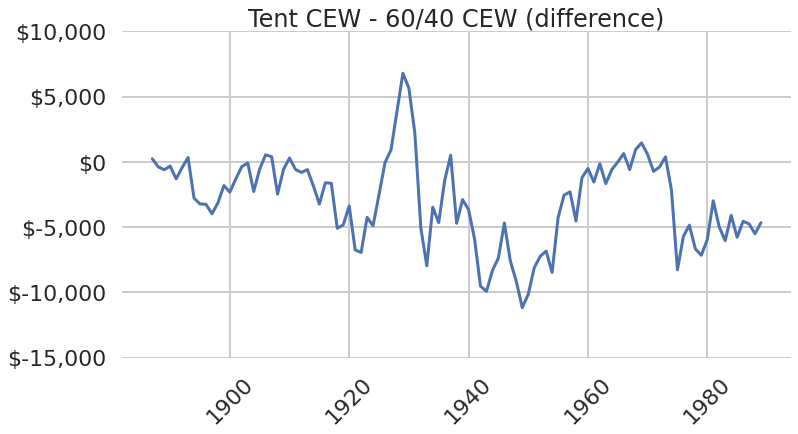

In [10]:
tent_wins = df[df['tent'] > df['static-60']]
print(len(tent_wins))
diff = df['tent'] - df['static-60']
plt.figure(figsize=(12,6))
plt.title('Tent CEW - 60/40 CEW (difference)')
def fmt_money(number):
    return "${:,.0f}".format(number)
seaborn.lineplot(data=diff.astype(float))
plt.xticks(rotation=45)
yticks = plt.yticks()
plt.yticks(yticks[0], [fmt_money(y) for y in yticks[0]])
seaborn.despine(left=True, bottom=True, offset=20)

In [11]:
diff[diff > 0]

1887     235.56586867348525759538064
1893     336.24770087419031510452300
1906     544.98107466059512181391115
1907     391.97041919588736411955182
1910     291.19464751917132605949364
1927     916.66063112552240982699075
1928    3859.39939871669874597920500
1929    6794.15083137520854737147156
1930    5650.50388752887632184396844
1931    2208.62645315964020776478908
1937     508.68406710010674960350421
1966     634.11821772930743603050500
1968     953.40263754817037725559334
1969    1453.34080698107839893660681
1970     563.76251045597060353050685
1973     376.58553676034228472725049
dtype: object

In [12]:
tent_loses = df[df['static-60'] > df['tent']]
print('Chance of tent wins', len(tent_wins) / (len(tent_wins) + len(tent_loses)))
print(diff[diff>0].median())
print(diff[diff<0].median())

Chance of tent wins 0.1553398058252427
598.940364092639
-3375.2052494195336


In [13]:
diff[diff<0].sort_values()

1949    -11171.00980743814201337789857
1950    -10150.14281830804666692445350
1943     -9920.65664879124877254440933
1942     -9527.89134450791033667774330
1948     -9164.64737334381268781388607
                     ...              
1890      -319.88309631949598319251469
1962      -147.44808487724440285609661
1903       -85.76527045924180546968907
1926       -58.68722078482114816530876
1965       -11.28841624695141742614606
Length: 87, dtype: object

In [14]:
def chart_one(year, lens):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : fn(lens, tent),
        'static-60' : fn(lens, static),
    })
    g = seaborn.relplot(
            data=df,
            kind='line',
            aspect=2,
        )
    g.fig.autofmt_xdate()
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle(f'Retirement in {year}')
    return g

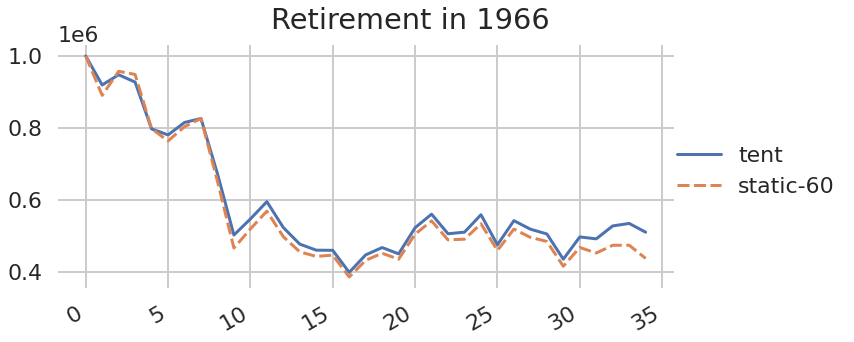

In [15]:
chart_one(1966, mk_lens('Portfolio (Real)'))
#chart_one(1929, mk_lens('Bond %'))
s = df.loc[1929]

In [16]:
def one(year, lens):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : fn(lens, tent),
        'static-60' : fn(lens, static),
    })
    return df

In [17]:
one(1929, mk_lens('Bond %')).head()

,tent,static-60
0,0.600000,0.400000
1,0.645304,0.447081
2,0.679495,0.497227
3,0.710274,0.545411
4,0.607514,0.442735


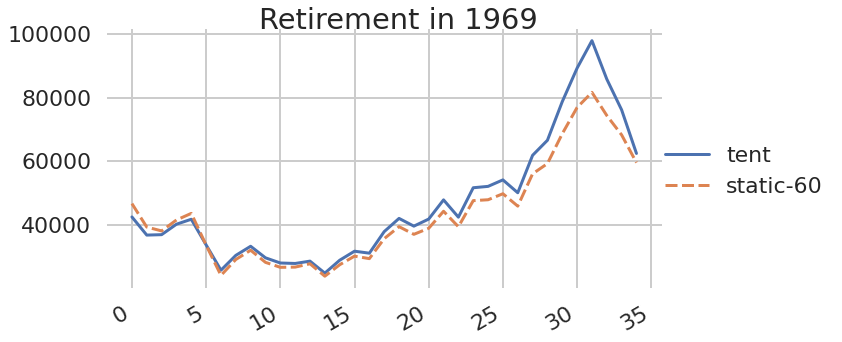

In [18]:
chart_one(1969, mk_lens('Withdrawal (Real)'))

In [19]:
def ulcer_one(year):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : [x.withdraw_r for x in tent],
        'static-60' : [x.withdraw_r for x in static],
    })
    return df.apply(metrics.ulcer)

def ulcer_all():
    df = pandas.DataFrame(index=range(1887, 2019 - 30 + 1), columns=['tent', 'static-60'])
    for i in range(1887, 2019 - 30 + 1):
        r = ulcer_one(i)
        df.loc[i] = r
    return df

In [20]:
ulcer_one(1929)

tent         0.152597
static-60    0.209243
dtype: float64

In [21]:
df = ulcer_all()
df.head()

,tent,static-60
1887,0.19421,0.196407
1888,0.208588,0.211833
1889,0.216439,0.222067
1890,0.22443,0.232215
1891,0.226779,0.237753


87


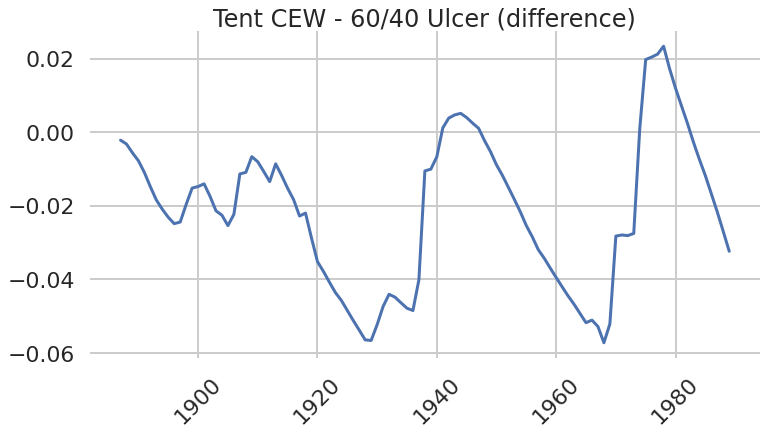

In [22]:
tent_wins = df[df['tent'] < df['static-60']]
print(len(tent_wins))
diff = df['tent'] - df['static-60']
plt.figure(figsize=(12,6))
plt.title('Tent CEW - 60/40 Ulcer (difference)')
seaborn.lineplot(data=diff.astype(float))
plt.xticks(rotation=45)
yticks = plt.yticks()
seaborn.despine(left=True, bottom=True, offset=20)

In [23]:
def get_rq(stock_pct, age, withdrawal_pct):
    # I can't figure out how to to joint life expectancy so I'll
    # just use female life expectancy for now :/
    life_expectancy = mortality.life_expectancy(None, age)
    mean = montecarlo.simba_mean[stock_pct]
    stddev = montecarlo.simba_stddev[stock_pct]
    
    return metrics.probability_of_ruin(mean, stddev, life_expectancy, float(withdrawal_pct))

def roundup(x):
    return int(math.ceil(float(x) / 10.0)) * 10

def rq_one_series(year):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : [x.withdraw_pct_cur for x in tent],
        'tent-stock' : [roundup(x.portfolio_pre.stocks / x.portfolio_pre.value_n) for x in tent],
        'static-60' : [x.withdraw_pct_cur for x in static],
    }, index=range(65,100))

    rq_tent = df.apply(lambda n: get_rq(n['tent-stock'], n.name, n['tent']), axis=1)
    rq_static = df.apply(lambda n: get_rq(60, n.name, n['static-60']), axis=1)
    return pandas.DataFrame({'tent': rq_tent, 'static-60': rq_static})

def rq_one(year):
    return rq_one_series(year).mean()

def rq_all():
    df = pandas.DataFrame(index=range(1887, 2019 - 35 + 1), columns=['tent', 'static-60'])
    for i in range(1887, 2019 - 35 + 1):
        r = rq_one(i)
        df.loc[i] = r
    return df

rq_one(1929).head()

tent         0.185813
static-60    0.119609
dtype: float64

In [24]:
df = rq_all()
df.head()

,tent,static-60
1887,0.186311,0.11992
1888,0.186435,0.11999
1889,0.186555,0.120083
1890,0.186533,0.120056
1891,0.186747,0.120208


0


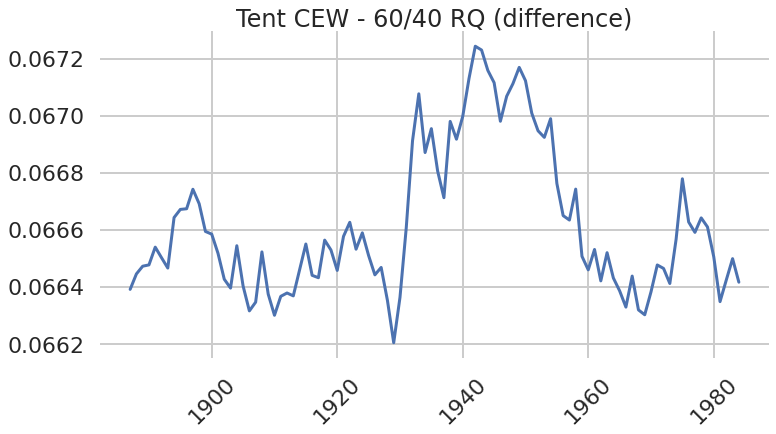

In [25]:
tent_wins = df[df['tent'] < df['static-60']]
print(len(tent_wins))
diff = df['tent'] - df['static-60']
plt.figure(figsize=(12,6))
plt.title('Tent CEW - 60/40 RQ (difference)')
seaborn.lineplot(data=diff.astype(float))
plt.xticks(rotation=45)
yticks = plt.yticks()
seaborn.despine(left=True, bottom=True, offset=20)

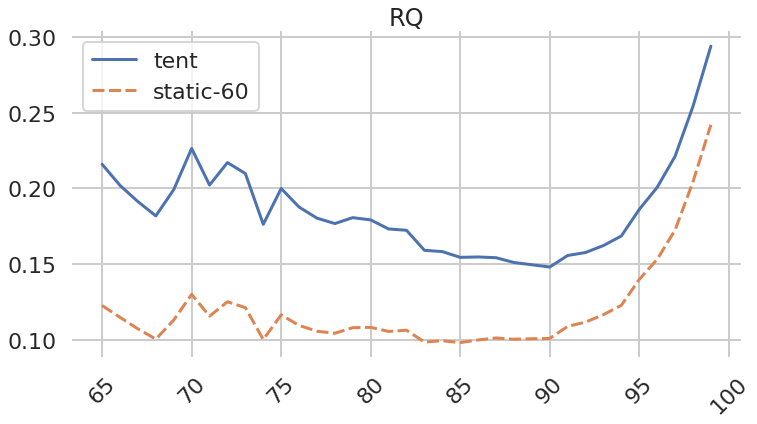

In [26]:
df = rq_one_series(1929)
plt.figure(figsize=(12,6))
plt.title('RQ')
seaborn.lineplot(data=df.astype(float))
plt.xticks(rotation=45)
yticks = plt.yticks()
seaborn.despine(left=True, bottom=True, offset=20)

In [32]:
def hreff_one(year):
    tent = run_sim(year, 'tent')
    static = run_sim(year, 'static-60')
    
    df = pandas.DataFrame({
        'tent' : [x.withdraw_pct_orig for x in tent],
        'static-60' : [x.withdraw_pct_orig for x in static],
        'returns' : [x.returns_r for x in tent]
    })
    tent_hreff = metrics.hreff(df['tent'], df['returns'])
    static_hreff = metrics.hreff(df['static-60'], df['returns'])
    return pandas.Series({'tent': tent_hreff, 'static-60': static_hreff})

def href_all():
    df = pandas.DataFrame(index=range(1887, 2019 - 30 + 1), columns=['tent', 'static-60'])
    for i in range(1887, 2019 - 30 + 1):
        r = hreff_one(i)
        df.loc[i] = r
    return df

hreff_one(1929)

tent          1.032829591871009522961161437
static-60    0.6699270009073079170519548178
dtype: object

In [30]:
df = href_all()
df.head()

NameError: name 'href_one' is not defined